In [43]:
import jax
import juniper as jp

from juniper import Gaussian
from juniper import LateralKernel
from juniper import NeuralField
from juniper import StaticGain
from juniper import GaussInput

#jax.config.update('jax_default_matmul_precision', 'bfloat16')

In [44]:
print("Computing devices found by JAX:")
print(jax.local_devices())

Computing devices found by JAX:
[CudaDevice(id=0)]


In [45]:
num_fields = 100
shape = (100,)
kernel_sigmas = (3,)
gauss_input_sigma = (6,)

# Some static parameters
kernel_amplitude = 0.2
amplitude = 0.2
factor = 4

In [46]:
arch = jp.Architecture.get_arch()
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()


st = StaticGain(f"st{1}", {"factor": factor})
g = GaussInput(f"gi{1}", {"shape": shape, "sigma": gauss_input_sigma, "amplitude": amplitude + 0.01, "center": [x // 2 for x in shape]})

kernel = Gaussian({"sigma": kernel_sigmas, "amplitude": kernel_amplitude, "normalized": False})

g >> st
nflast = None
for i in range(num_fields):
        nf = NeuralField(f"nf{i}", {"resting_level": -0.7-i*0.001, "global_inhibition": -0.0000001+i*0.00000001, "tau": 1., 
                                "sigmoid": "AbsSigmoid", "beta": 100+i*0.001, "theta": 0+i*0.001,
                        "input_noise_gain": 0.001+i*0.0001, "shape": shape, "LateralKernel": kernel})
        from_element = st
        nf << from_element
        """if nflast is not None:
                nflast >> nf
        nflast = nf"""


arch.compile(tick_func=arch.tick, warmup=10)

In [47]:
recording_tick=[]
arch.reset_steps()
recording_tick, ms_per_tick, timing = arch.run_simulation(arch.tick, ["nf1.activation", "st1"], 200, print_timing=True)

 21.10 ms / time step
  4.22 s total duration

 20.57 ms average time for computation
Saving buffers... done


In [48]:
arch2 = jp.Architecture.get_arch()
jp.Architecture.delete_arch()
arch2 = jp.Architecture.get_arch()

st = StaticGain(f"st{1}", {"factor": factor})
g = GaussInput(f"gi{1}", {"shape": shape, "sigma": gauss_input_sigma, "amplitude": amplitude + 0.01, "center": [x // 2 for x in shape]})

kernel = Gaussian({"sigma": kernel_sigmas, "amplitude": kernel_amplitude, "normalized": False})

g >> st
nflast = None
for i in range(num_fields):
        nf = NeuralField(f"nf{i}", {"resting_level": -0.7-i*0.001, "global_inhibition": -0.0000001+i*0.00000001, "tau": 1., 
                                "sigmoid": "AbsSigmoid", "beta": 100+i*0.001, "theta": 0+i*0.001,
                        "input_noise_gain": 0.001+i*0.0001,"shape": shape, "LateralKernel": kernel})
        from_element = st
        nf << from_element
        """if nflast is not None:
                nflast >> nf
        nflast = nf"""


arch2.compile(tick_func=arch.tick_jitted, warmup=10)

In [49]:
recording_tick_jitted=[]
arch2.reset_steps()
recording_tick_jitted, ms_per_tick, timing = arch2.run_simulation(arch2.tick_jitted, ["nf1.activation", "st1"], 200, print_timing=True)

192.21 ms / time step
 38.44 s total duration

191.66 ms average time for computation
Saving buffers... done


(200, 2, 100)
(200, 2, 100)
1.4560319
1.4560227


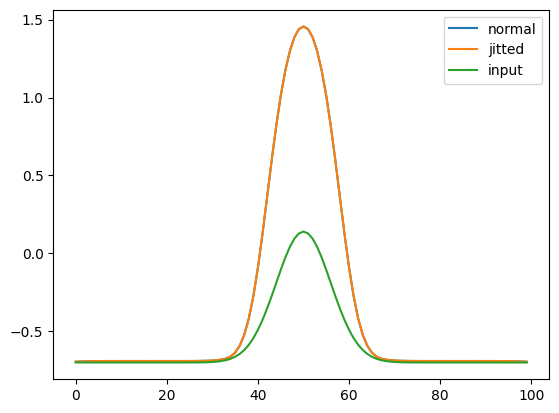

In [50]:
import matplotlib.pyplot as plt
import numpy as np
low_range = -1
print(np.asarray(recording_tick).shape)
print(np.asarray(recording_tick_jitted).shape)
print(np.max(recording_tick[low_range][0]))
print(np.max(recording_tick_jitted[low_range][0]))
plt.plot(recording_tick[low_range][0], label="normal")
plt.plot(recording_tick_jitted[low_range][0], label="jitted")
plt.plot(recording_tick[low_range][1]-0.7, label="input")
plt.legend()
plt.show()